# Exploration des meilleurs modèles

### Avec les explorations des modèles précédents, nous avons pu constater que :

De nombreux modèles ont des performances excellentes, Random Forest, Gradient Boosting, SVM, KNN, etc. Que ça soit pour la classification de la vitesse ou des déplacements, les résultats sont très bons.

L'idée initiale était d'explorer les hyperparamètres de ces modèles pour essayer de les améliorer, mais vu les résultats obtenus, il n'est pas nécessaire de le faire pour l'instant.

Cependant, nous allons quand même explorer des modèles ANN (Artificial Neural Network) pour voir si l'on peut augmenter le taux des prédictions neutres pour le mouvement et des classe 2 pour la vitesse. Dans le but de réduire les mouvements qui devraient être neutres et les vitesses qui devraient être de classe 2, pour éviter les incrémentations et les décrémentations de la vitesse quand ce n'est pas souhaitée.

### ANN pour la classification des déplacements

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

data = pd.read_csv('../preprocessing_data/move_preprocess.csv')

X = data.drop('action', axis=1)
y = data['action']

le = LabelEncoder()
y = le.fit_transform(y)

print(le.classes_)


X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

['ARRIERE' 'AVANT' 'DROITE' 'GAUCHE' 'NEUTRE' 'SURPRISE' 'TOURNER_DROITE'
 'TOURNER_GAUCHE']


In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
import numpy as np

def create_ann_model(input_dim, nb_outputs, nb_layers=2, nb_neurons=8, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(nb_neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    for _ in range(nb_layers - 1):
        model.add(Dense(nb_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(nb_outputs, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

clf = KerasClassifier(
    model=create_ann_model,
    input_dim=X_train.shape[1],
    nb_outputs=len(np.unique(y_train)),
    verbose=0
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

import numpy as np



param_dist = {
    'model__nb_layers': [2, 3, 5],
    'model__nb_neurons': [8, 16, 32, 64],
    'model__dropout_rate': [0.2, 0.3, 0.5],
    'model__activation': ['relu', 'tanh'],
    'epochs': [30, 50, 100],
    'batch_size': [32, 64, 128],
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train, y_train)

In [ ]:
print("Meilleurs hyperparamètres :")
print(random_search.best_params_)

print("Meilleur score (validation croisée) :")
print(random_search.best_score_)

from sklearn.metrics import accuracy_score

y_pred = random_search.predict(X_val)
print("Score sur validation :", accuracy_score(y_val, y_pred))

Recherche plus exhaustive des hyperparamètres pour l'ANN, en utilisant GridSearchCV. Autour des meilleurs hyperparamètres trouvés précédemment par RandomizedSearchCV.

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier


clf = KerasClassifier(
    model=create_ann_model,
    input_dim=X_train.shape[1],
    nb_outputs=len(np.unique(y_train)),
    verbose=0
)

param_grid = {
    'model__nb_neurons': [16, 32],
    'model__nb_layers': [2, 3, 5],
    'model__activation': ['tanh'],
    'model__dropout_rate': [0.2],
    'epochs': [100],
    'batch_size': [32]
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

grid_search.fit(
    X_train, y_train,
    **{
        'callbacks': [early_stop],
        'validation_split': 0.2,
        'verbose': 1
    }
)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2553 - loss: 1.9387 - val_accuracy: 0.8690 - val_loss: 1.1411
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7627 - loss: 1.0741 - val_accuracy: 0.9320 - val_loss: 0.5997
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.6164 - val_accuracy: 0.9420 - val_loss: 0.3755
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9282 - loss: 0.4440 - val_accuracy: 0.9453 - val_loss: 0.2780
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9303 - loss: 0.3752 - val_accuracy: 0.9469 - val_loss: 0.2305
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9371 - loss: 0.3035 - val_accuracy: 0.9502 - val_loss: 0.1984
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9490 - loss: 0.2752 - val_accuracy: 0.9486 - val_loss: 0.1814
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

GridSearchCV(cv=3,
             estimator=KerasClassifier(input_dim=34, model=<function create_ann_model at 0x000001C565AEF420>, nb_outputs=8, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [32], 'epochs': [100],
                         'model__activation': ['tanh'],
                         'model__dropout_rate': [0.2],
                         'model__nb_layers': [2, 3, 5],
                         'model__nb_neurons': [16, 32]},
             verbose=1)

In [62]:
print("Best params (Grid Search):", grid_search.best_params_)
print("Best score (Grid Search):", grid_search.best_score_)

Best params (Grid Search): {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__dropout_rate': 0.2, 'model__nb_layers': 2, 'model__nb_neurons': 32}
Best score (Grid Search): 0.9900388476006244


Il est temps d'étudier l'entrainement du modèle avec les meilleurs hyperparamètres trouvés.

On repasse entièrement sur keras


Accuracy du meilleur modèle sur le jeu de validation :

In [63]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout


best_model = create_ann_model(input_dim=X_train.shape[1],
    nb_outputs=len(np.unique(y_train)),
    nb_layers=grid_search.best_params_['model__nb_layers'],
    nb_neurons=grid_search.best_params_['model__nb_neurons'],
    dropout_rate=grid_search.best_params_['model__dropout_rate'],
    activation=grid_search.best_params_['model__activation']
)
history = best_model.fit(
    X_train, y_train,
    epochs=grid_search.best_params_['epochs'],
    batch_size=grid_search.best_params_['batch_size'],
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3391 - loss: 1.8042 - val_accuracy: 0.8226 - val_loss: 1.0285
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 0.9399 - val_accuracy: 0.9287 - val_loss: 0.5464
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9175 - loss: 0.5559 - val_accuracy: 0.9552 - val_loss: 0.3493
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9433 - loss: 0.3819 - val_accuracy: 0.9569 - val_loss: 0.2439
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9470 - loss: 0.3013 - val_accuracy: 0.9569 - val_loss: 0.1973
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9481 - loss: 0.2545 - val_accuracy: 0.9635 - val_loss: 0.1666
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9626 - loss: 0.1983 - val_accuracy: 0.9635 - val_loss: 0.1454
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9626 - loss: 0.2108 - val_accuracy: 0.9652 - v

In [64]:
from sklearn.metrics import accuracy_score

y_pred_prob = best_model.predict(X_val)
y_pred = y_pred_prob.argmax(axis=1)

print("Accuracy sur le jeu de validation :", accuracy_score(y_val, y_pred))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy sur le jeu de validation : 0.9933598937583001


In [65]:
print(best_model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,322 (28.61 KB)

 Trainable params: 2,440 (9.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,882 (19.07 KB)

None


print(keras_model.summary())Etude de l'entrainement (erreur à chaque epoch) du modèle avec les meilleurs hyperparamètres trouvés.

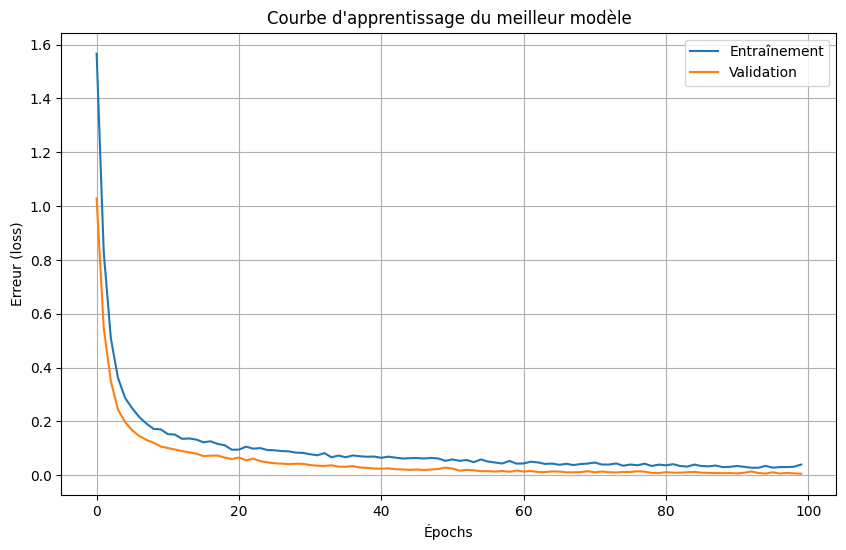

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Épochs")
plt.ylabel("Erreur (loss)")
plt.title("Courbe d'apprentissage du meilleur modèle")
plt.legend()
plt.grid(True)
plt.show()

Maintenant le but va être de trouver un seuil idéale à partir des sorties des neurones pour augmenter le taux de prédictions neutres, et éviter ainsi des mouvements non souhaités (les minimiser en les classifiant comme neutres).

Pour cela nous allons étudier la différence entre la sortie du neurone avec la plus grande valeur et la seconde plus grande valeur. Si cette différence est trop faible, on va considérer que le modèle n'est pas sûr de sa prédiction et on va la classer comme neutre.

In [67]:
print(le.classes_)

['ARRIERE' 'AVANT' 'DROITE' 'GAUCHE' 'NEUTRE' 'SURPRISE' 'TOURNER_DROITE'
 'TOURNER_GAUCHE']


Neutre correspond à la classe 4

Méthode A avec delta comme seuil :
- pour chaque échantillon, on calcule la différence entre la probabilité maximale (p_max) et la seconde probabilité maximale (p_2nd) et on compare cette différence à un seuil delta. Si (p_max - p_2nd) < delta, on classe l'échantillon comme neutre.

Méthode B avec alpha comme seuil :
- pour chaque échantillon, on calcule la différence de la probabilité de la classe neutre (p_neutre) et la probabilité de la classe neutre et on la compare à un seuil alpha. Si p_neutre >= alpha, on classe l'échantillon comme neutre.

In [68]:
# Code généré ici à l'aide chatGPT

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Méthode A
delta_list = [0.05, 0.10, 0.20]
# Méthode B
alpha_list = [0.30, 0.40, 0.50]

probas_train = best_model.predict(X_train)

print("Shape des probas_train :", probas_train.shape)

print("Accuracy sur le jeu d'entraînement :", accuracy_score(y_train, probas_train.argmax(axis=1)))

p_neutre_all = probas_train[:, 4]

# Pour calculer (p_max - p_2nd) pour chaque échantillon, on fait :
# 1) on trie chaque ligne de probas_train pour isoler p_max et p_2nd
# 2) on calcule la différence
sorted_indices = np.argsort(probas_train, axis=1)
# p_sorted[i, -1] = p_max pour l'échantillon i
# p_sorted[i, -2] = p_2nd pour l'échantillon i
p_sorted = np.take_along_axis(probas_train, sorted_indices, axis=1)
p_max_all = p_sorted[:, -1]    # vecteur de taille N_train
p_2nd_all = p_sorted[:, -2]    # vecteur de taille N_train

delta_all = p_max_all - p_2nd_all  # vecteur (p_max - p_2nd) pour chaque échantillon

# --- 2.4. Boucle sur toutes les combinaisons (delta, alpha) ---
# On va construire une liste de lignes pour un DataFrame, où chaque ligne contiendra :
#    [delta, alpha, accuracy]
records = []

for delta in delta_list:
    for alpha in alpha_list:
        # Pour chaque échantillon i, on décide la prédiction finale selon :
        #   si p_neutre >= alpha  OU  delta_i < delta  => classe 2 (neutre)
        #   sinon                                      => argmax(probas_train[i])
        # On peut vectoriser cette logique en deux étapes :

        # Étape 1 : on initialise pred = argmax(probas_train, axis=1)
        preds_argmax = np.argmax(probas_train, axis=1)

        # Étape 2 : on marque en 2 (neutre) tous les indices i où
        #           p_neutre_all[i] >= alpha   OU   delta_all[i] < delta
        # On crée un masque booléen "to_neutral" de taille N_train :
        to_neutral = np.logical_or(p_neutre_all >= alpha, delta_all < delta)

        # On remplace dans preds_argmax(i) par 2 si to_neutral[i] est True
        final_preds = preds_argmax.copy()
        final_preds[to_neutral] = 4

        # --- 2.5. Calcul de l’accuracy sur X_train/y_train pour ce (delta, alpha) ---
        acc = accuracy_score(y_train, final_preds)

        # On stocke le triplet
        records.append({
            'delta': delta,
            'alpha': alpha,
            'accuracy': acc
        })

# --- 2.6. Construction du DataFrame 3×3 « matrice » ---
df_results = pd.DataFrame(records)

# Pivot : ligne = delta, colonne = alpha, valeur = accuracy
matrix_acc = df_results.pivot(index='delta', columns='alpha', values='accuracy')

# Affichage
print("Matrice des accuracies (rows = delta, cols = alpha) :\n")
print(matrix_acc)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Shape des probas_train : (3011, 8)
Accuracy sur le jeu d'entraînement : 0.9976751909664563
Matrice des accuracies (rows = delta, cols = alpha) :

alpha       0.3       0.4       0.5
delta                              
0.05   0.998339  0.998339  0.997675
0.10   0.998339  0.998339  0.998007
0.20   0.998339  0.998339  0.998339


On remarque étonnament que les seuils améliorent l'accuracy du modèle, ce qui n'était pas attendu. En effet, on s'attendait à ce que les seuils réduisent l'accuracy en classifiant des échantillons comme neutres alors qu'ils ne le sont pas.

On conservera le seuil delta = 0.20 et alpha = 0.30, car il permet d'augmenter l'accuracy du modèle tout en réduisant les mouvements non souhaités.

Sauvegarde du meilleur modèle :

In [69]:
import joblib

best_model.save('../models_ANN/best_ann_model_move.h5')
joblib.dump(le, "../models_ANN/label_encoder_move.pkl")

['../models_ANN/label_encoder_move.pkl']

Finalement je ne vais pas étudier la position 2 pour la vitesse de la même façon que le neutre du mouvement, cela ne servirait à rien car la position 2 n'est pas vraiment considéré comme une position neutre.